In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2,os
import numpy as np

data_path='/content/drive/MyDrive/MedicalExpert'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
label_dict=dict(zip(categories,labels))
print(label_dict)
print(categories)
print(labels)




{'0Normal': 0, '4Severe': 1, '1Doubtful': 2, '3Moderate': 3, '2Mild': 4}
['0Normal', '4Severe', '1Doubtful', '3Moderate', '2Mild']
[0, 1, 2, 3, 4]


In [3]:
for category in categories:
    class_path = os.path.join(data_path, category)
    images = os.listdir(class_path)


    images = [img for img in images if img.endswith(".jpg") or img.endswith(".png")]


    print(f"Nombre d'images dans la classe {category}: {len(images)}")


Nombre d'images dans la classe 0Normal: 514
Nombre d'images dans la classe 4Severe: 206
Nombre d'images dans la classe 1Doubtful: 490
Nombre d'images dans la classe 3Moderate: 221
Nombre d'images dans la classe 2Mild: 232


##Data augmentation

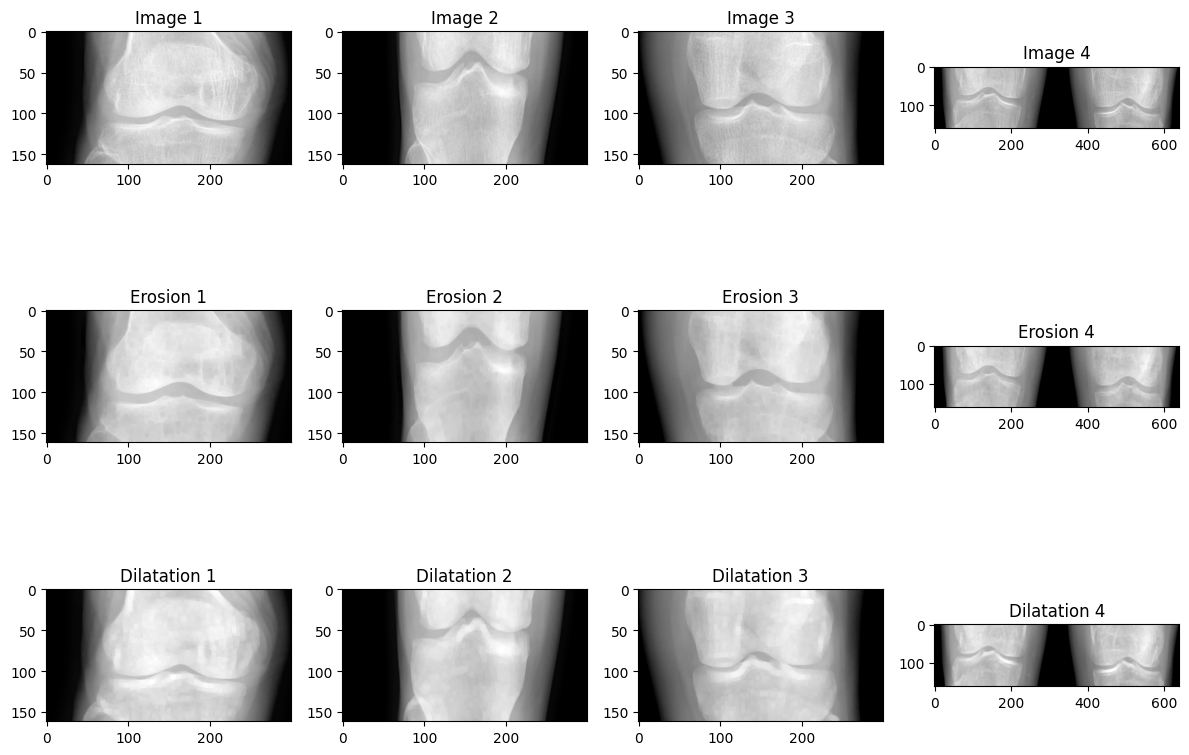

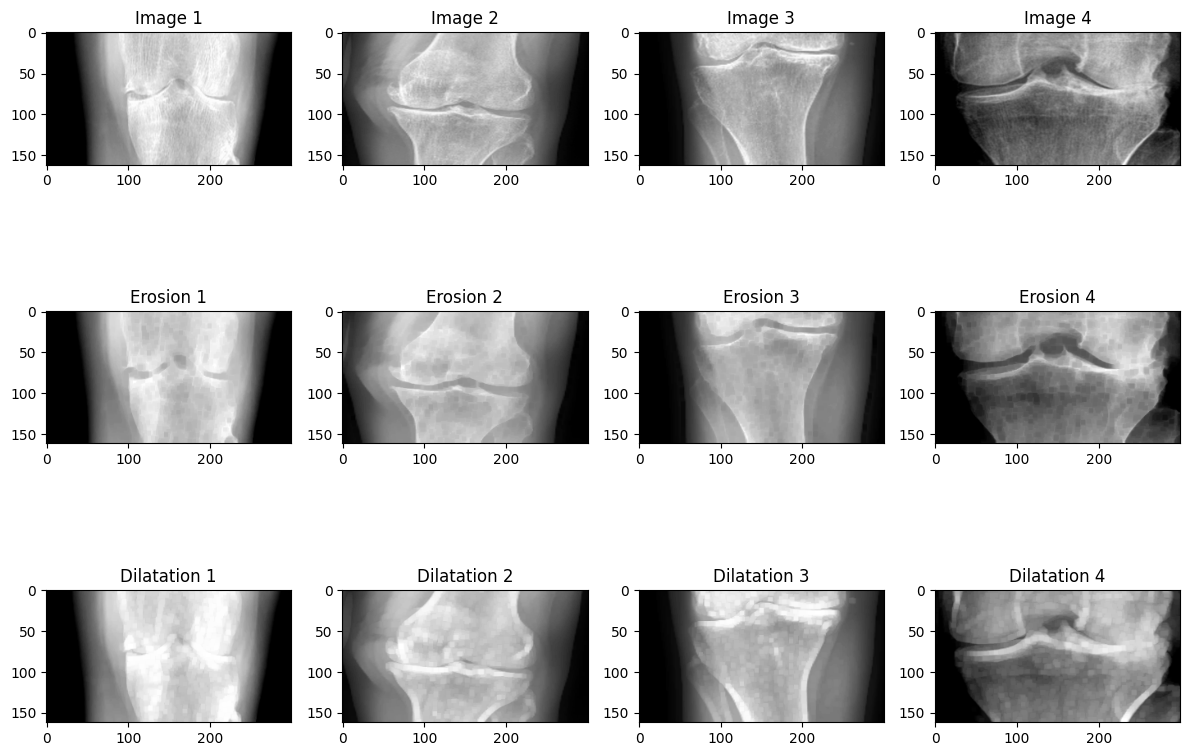

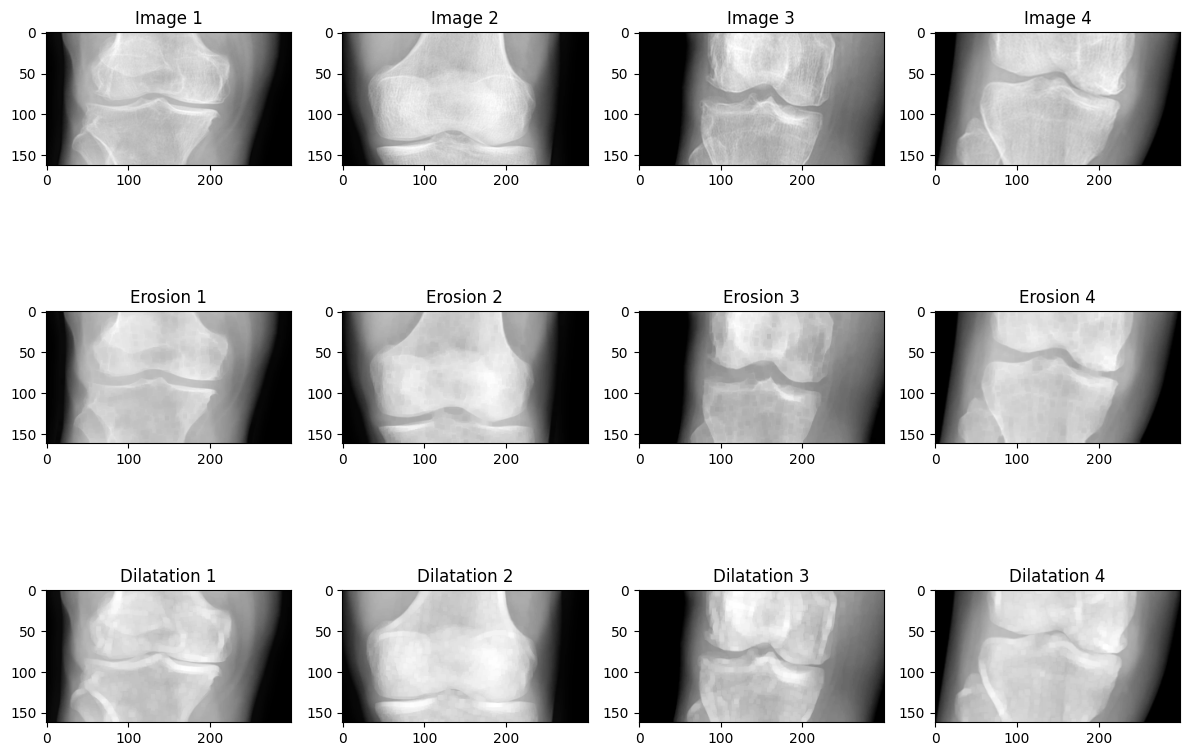

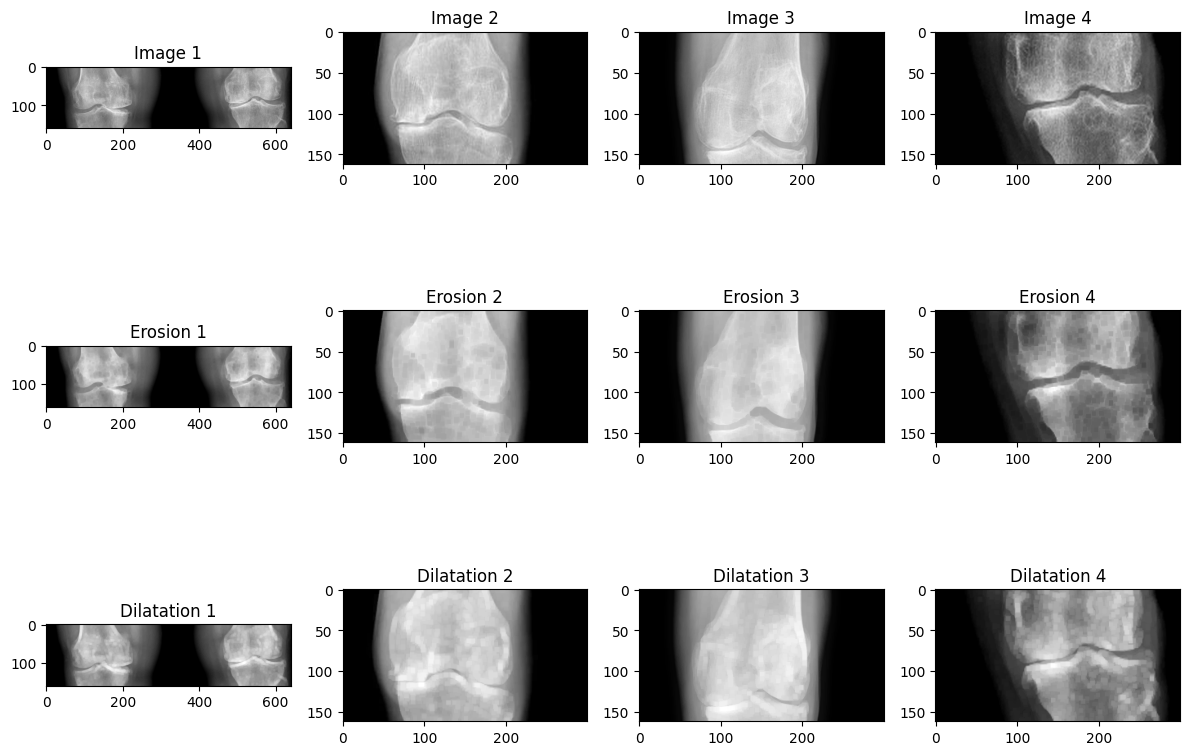

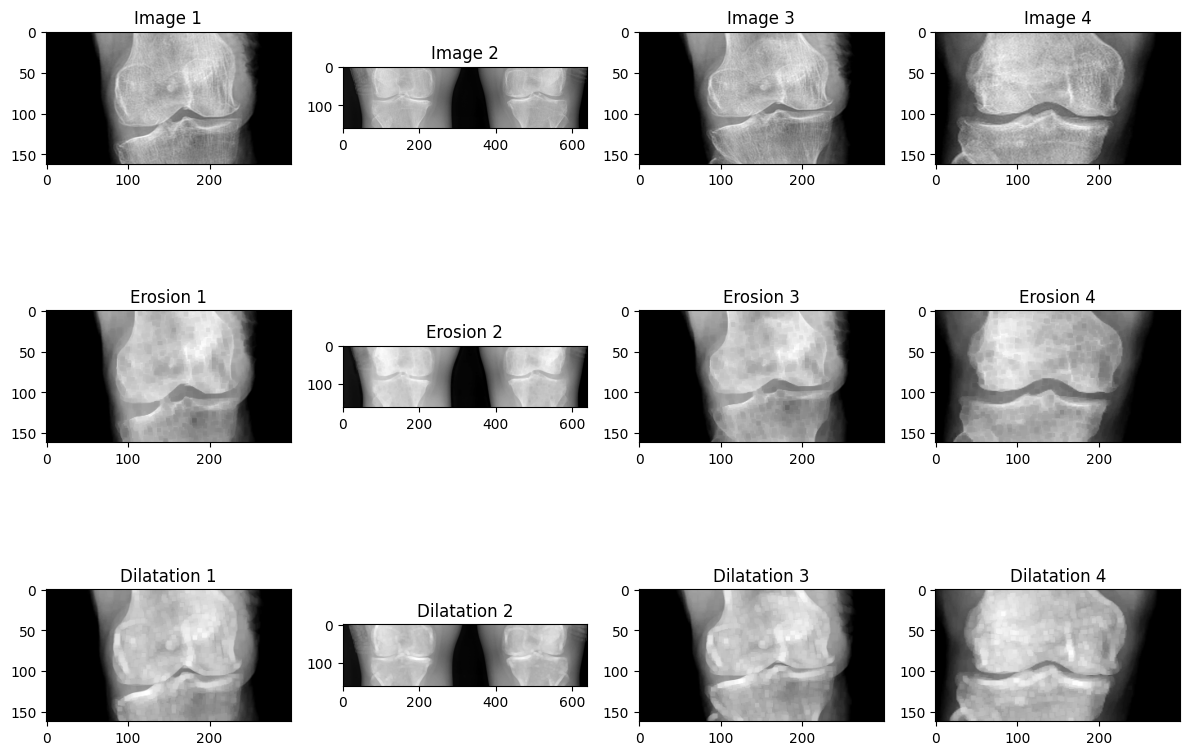

In [4]:
import random
import matplotlib.pyplot as plt

def visualize_data_augmentation(category, data_path):

    class_path = os.path.join(data_path, category)
    images = os.listdir(class_path)
    images = [img for img in images if img.endswith(".jpg") or img.endswith(".png")]


    selected_image_names = random.sample(images, 4)


    plt.figure(figsize=(12, 9))
    for idx, img_name in enumerate(selected_image_names):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Lire l'image en niveaux de gris
        plt.subplot(3, 4, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Image {idx+1}')

    # les images érodées
    for idx, img_name in enumerate(selected_image_names):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Lire l'image en niveaux de gris
        kernel = np.ones((5, 5), np.uint8)
        eroded = cv2.erode(img, kernel, iterations=1)

        plt.subplot(3, 4, idx + 5)
        plt.imshow(eroded, cmap='gray')
        plt.title(f'Erosion {idx+1}')

    #  images dilatées
    for idx, img_name in enumerate(selected_image_names):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        kernel = np.ones((5, 5), np.uint8)
        dilated = cv2.dilate(img, kernel, iterations=1)

        plt.subplot(3, 4, idx + 9)
        plt.imshow(dilated, cmap='gray')
        plt.title(f'Dilatation {idx+1}')

    plt.tight_layout()
    plt.show()



for category in categories:
    visualize_data_augmentation(category, data_path)


In [5]:

data = []
label = []
data_augmented = {}
desired_images = 500
img_size = 256


for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)


    count = 0


    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))


            data.append(resized)
            label.append(label_dict[category])


            if category not in data_augmented:
                data_augmented[category] = 0
            data_augmented[category] += 1


            if category in ['4Severe', '3Moderate', '2Mild'] and data_augmented[category] < desired_images:

                kernel = np.ones((5, 5), np.uint8)
                eroded = cv2.erode(resized, kernel, iterations=1)
                dilated = cv2.dilate(resized, kernel, iterations=1)


                data.extend([eroded, dilated])
                label.extend([label_dict[category]] * 2)  #  deux images augmentées


                if category not in data_augmented:
                    data_augmented[category] = 0
                data_augmented[category] += 2

        except Exception as e:
            print('Exception:', e)




# Afficher le nombre total d'images après augmentation pour chaque classe
for category, count in data_augmented.items():
    print(f"Nombre total d'images après augmentation pour la classe {category}: {count}")


Nombre total d'images après augmentation pour la classe 0Normal: 514
Nombre total d'images après augmentation pour la classe 4Severe: 540
Nombre total d'images après augmentation pour la classe 1Doubtful: 490
Nombre total d'images après augmentation pour la classe 3Moderate: 555
Nombre total d'images après augmentation pour la classe 2Mild: 566


In [6]:
print(len(data))
print(len(label))

2665
2665


In [7]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))

label=np.array(label)
from keras.utils import to_categorical
new_label = to_categorical(label)

In [8]:
print(data[0].shape)

(256, 256, 1)


split data

In [31]:
train_data, test_data, train_labels, test_labels = train_test_split(data, new_label, test_size=0.1)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1)

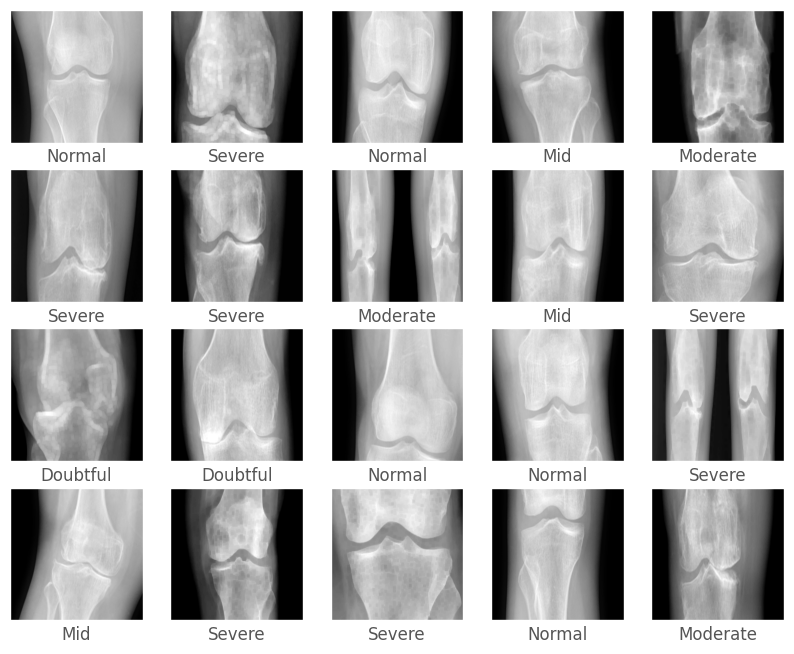

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
random_indices = random.sample(range(len(test_data)), 20)

for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(test_data[idx]), cmap='gray')
    plt.xlabel(categories[np.argmax(test_labels[idx])])

plt.show()


#CNN


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Activation
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D





In [10]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

2158
267
240


In [11]:
# (256, 256, 1) SHAPE
model=Sequential()
model.add(Conv2D(128,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))

model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))

model.add(Dense(5,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
# architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     1280      
                                                                 
 activation (Activation)     (None, 254, 254, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

In [13]:
#  (GPU si disponible, sinon CPU)
device = '/device:GPU:0' if tf.config.list_physical_devices('GPU') else '/device:CPU:0'


In [14]:
print(device)

/device:GPU:0


In [15]:
with tf.device(device):
    history = model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels))

Epoch 1/50
68/68 [==============================] - 18s 154ms/step - loss: 1.5865 - accuracy: 0.2516 - val_loss: 1.5172 - val_accuracy: 0.3125
Epoch 2/50
68/68 [==============================] - 8s 121ms/step - loss: 1.5157 - accuracy: 0.3267 - val_loss: 1.4604 - val_accuracy: 0.3500
Epoch 3/50
68/68 [==============================] - 8s 123ms/step - loss: 1.4723 - accuracy: 0.3656 - val_loss: 1.4391 - val_accuracy: 0.3458
Epoch 4/50
68/68 [==============================] - 8s 123ms/step - loss: 1.4477 - accuracy: 0.3582 - val_loss: 1.4535 - val_accuracy: 0.3458
Epoch 5/50
68/68 [==============================] - 9s 136ms/step - loss: 1.4034 - accuracy: 0.4087 - val_loss: 1.4145 - val_accuracy: 0.4000
Epoch 6/50
68/68 [==============================] - 9s 125ms/step - loss: 1.3502 - accuracy: 0.4356 - val_loss: 1.3135 - val_accuracy: 0.4083
Epoch 7/50
68/68 [==============================] - 9s 129ms/step - loss: 1.2903 - accuracy: 0.4634 - val_loss: 1.2673 - val_accuracy: 0.4583
Epoch

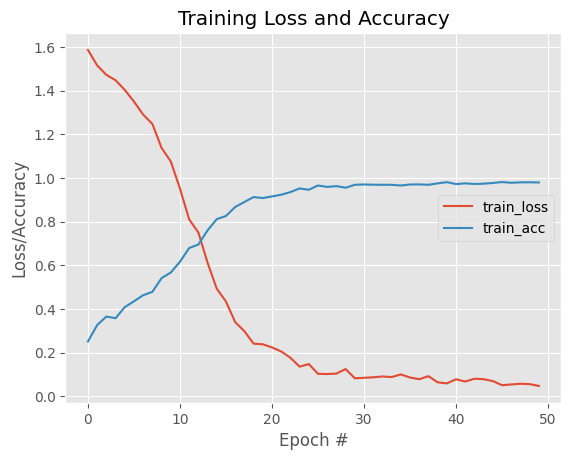

In [25]:
from matplotlib import pyplot as plt
N = 50 #nombre epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

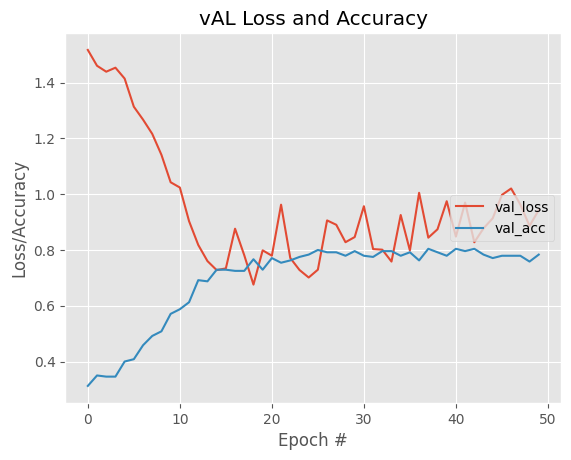

In [26]:

# plot the training loss and accuracy
N = 50 #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("vAL Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

In [17]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

9/9 [==============================] - 1s 72ms/step - loss: 1.6850 - accuracy: 0.7228
Test Loss: 1.6849557161331177, Test Accuracy: 0.7228464484214783


In [18]:
model.save('model_cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

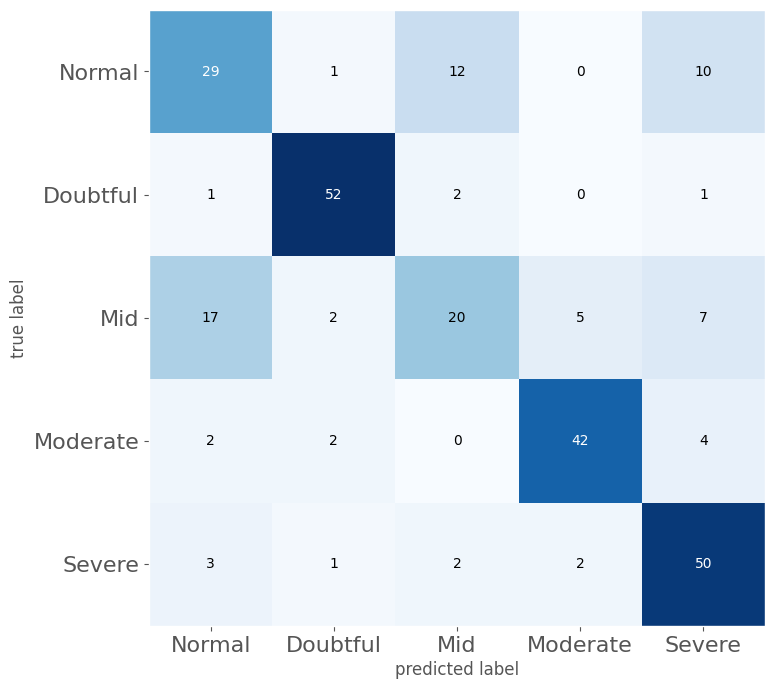

In [19]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(test_labels, axis=1)
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(5), ['Normal', 'Doubtful', 'Mid', 'Moderate', 'Severe'], fontsize=16)
plt.yticks(range(5), ['Normal', 'Doubtful', 'Mid', 'Moderate', 'Severe'], fontsize=16)
plt.show()

- normal ( - )
- mid ( - )

1/1 [==============================] - 0s 26ms/step
Model_Cnn prédit : Normal
Prédiction correcte pour l'étiquette 0 est Normal


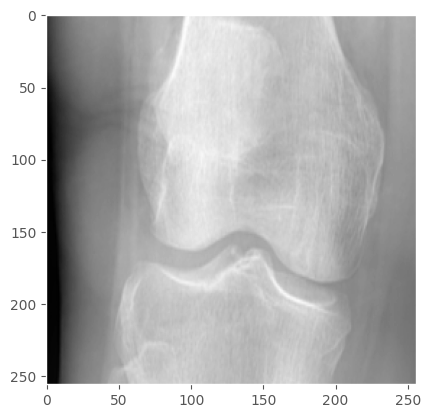

In [23]:
X = 120
img_size = 256
img_single = test_data[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = (np.expand_dims(img_single, 0))
img_single = img_single.reshape(img_single.shape[0], 256, 256, 1)

predictions_single = model.predict(img_single)

categories = ['Normal', 'Doubtful', 'Mid', 'Moderate', 'Severe']

print('Model_Cnn prediction :', categories[np.argmax(predictions_single)])
print("y label ", np.argmax(test_labels[X]), 'is', categories[np.argmax(test_labels[X])])

plt.imshow(np.squeeze(test_data[X]), cmap='gray')
plt.grid(False)
plt.show()